In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
sb.set() 

__Done by__:
Thng Ling Peng U2223162D
Tong Yan Yong Theodore U22233220B

__Problem statement__: We look at past data for HDB resale prices. so that we can recommend people how much to price their resale HDB flats based on several features or how likely they can sell it for a certain mark up price.

__Application__: This project is applicable not just for property agents trying to buy and sell, but for potential home buyers looking to buy a reasonably priced flat as well. 

This project is also applicable for the government to access the financial health (accounting stuff) of certain HDB flats as well. This will help them guide decisions and policies on housing matters for the future. 

__Organization of report__:

1. Dataset exploration
2. Intro to Gradient Boosting Regression (GBR)
3. Dataset preprocessing
4. GBR with one column to predict resale_price
5. GBR with multiple columns to predict resale_price
6. Comparing GBR with linear regression and random guessing
7. More experimnts with GBR hyperparameters
8. Conclusion

# 1. Dataset exploration

In [3]:
maindf = pd.read_csv('resale_flat_prices_based_on_registration_date_from_jan_2017_onwards.csv')

town = pd.DataFrame(maindf['town'])
fm = pd.DataFrame(maindf['flat_model'])
ft = pd.DataFrame(maindf['flat_type'])
sr = pd.DataFrame(maindf['storey_range'])
rp = pd.DataFrame(maindf['resale_price'])
fas = pd.DataFrame(maindf['floor_area_sqm'])
lcd = pd.DataFrame(maindf['lease_commence_date'])

maindf

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,Improved,1987,66 years 03 months,440000.0
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,Improved,1987,65 years 06 months,458000.0
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,Improved,1987,66 years 04 months,490000.0
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,Maisonette,1987,66 years 03 months,558000.0


A few columns are not worth exploring. 

__month__: month where hdb resale is first listed on property websites

__block__: hdb block number. They are assigned based on town. The numeric value means nothing. It is more of a categorical data than numeric. Might as well use the town column. Its more relatable as well.

__street_name__: town but in more detail. Just use town column 

__remaining lease__: directly correlated to lease_commence_date column. Might as well use that column. lease_commence_date is numerical data too, easier to handle. Furthermore, difference between months don't matter as much as years.

In [4]:
#checking for any faulty data entries
print("checking for NaN (not a number):");
print(maindf.isna().sum())
print("\nflat type unique entries:")
unique_entries = maindf['flat_type'].unique()
print(unique_entries)
print("\nflat model unique entries:")
unique_entries = maindf['flat_model'].unique()
print(unique_entries)
print("\nstorey range unique entries:")
unique_entries = maindf['storey_range'].unique()
print(unique_entries)
print("\ntown unique entries:")
unique_entries = maindf['town'].unique()
print(unique_entries)
print("\ndtypes of all columns:")
print(maindf.dtypes)

checking for NaN (not a number):
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

flat type unique entries:
['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI-GENERATION']

flat model unique entries:
['Improved' 'New Generation' 'DBSS' 'Standard' 'Apartment' 'Simplified'
 'Model A' 'Premium Apartment' 'Adjoined flat' 'Model A-Maisonette'
 'Maisonette' 'Type S1' 'Type S2' 'Model A2' 'Terrace'
 'Improved-Maisonette' 'Premium Maisonette' 'Multi Generation'
 'Premium Apartment Loft' '2-room']

storey range unique entries:
['10 TO 12' '01 TO 03' '04 TO 06' '07 TO 09' '13 TO 15' '19 TO 21'
 '22 TO 24' '16 TO 18' '34 TO 36' '28 TO 30' '37 TO 39' '49 TO 51'
 '25 TO 27' '40 TO 42' '31 TO 33' '46 TO 48' '43 TO 45']

town unique entries:
['ANG MO

Lets explore the dataset in more detail. This is to check for any oddities that may need further cleaning. 

__Numeric columns:__ The dataset contains no 'NaN'(not a number). So the columns with float64 datatype is fine. 

__Categorical columns:__ no entries are mispelled.

__Changing categorical data to numeric data?__ Some columns can be represented by numbers instead such as storey_range and flat_type. But we decided to leave it as it is because it is unreasonable to quantify 'EXECUTIVE" and "MULTI-GENERATION" for flat_type. As for storey range, we cannot say for sure which floor every entry belongs to so it is better to just leave unchanged. There is a huge difference between floor 1 and floor 3 as well. 

__Data types__: month is a column that is not worth exploring so even if the dtype is wrong, there is no need to alter. Same goes for block and remaining_lease. 

Side note, some blocks have letters in them like 179A, 179B, 179C and so on. It means that these group of HDB belong together like a unit. So block column being an object rather than int64 is expected. Removing the letters can be considered but this column is still categorical data rather than numeric data. As expressed before, the numeric value does nothing. 

__Further cleaning__ includes removing outliers from numeric data but this is especially tricky. Outliers in floor_area_sqm may mean an abnormally large house but these houses all belong to a certain categories like "MULTI-GENERATION". If we were to blindly remove outliers, most of the "MULTI-GENERATION" entries will be wiped out. A misrepresentation of the overall data. For now we will leave numeric outliers alone

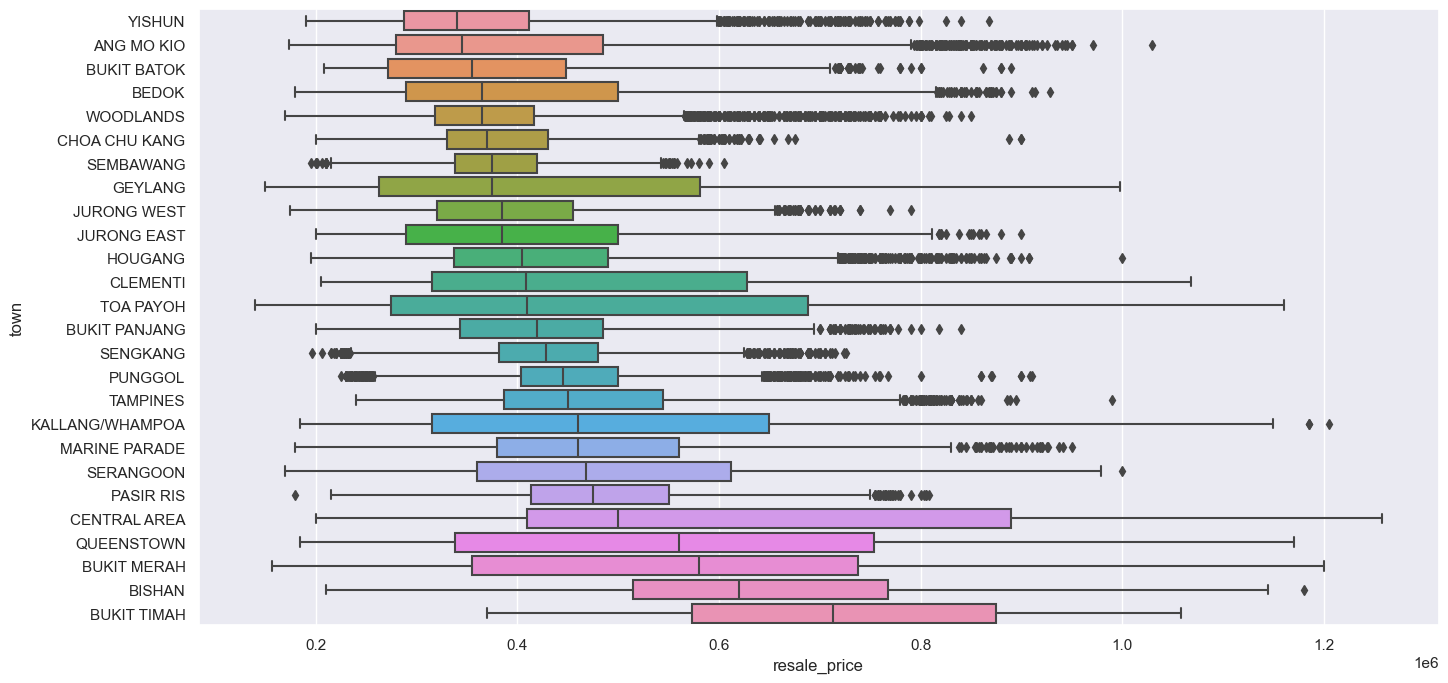

In [6]:
def sorted_boxplot(df1name,df1,df2):
    testdf = pd.concat([df1,df2], axis = 1)
    f = plt.figure(figsize = (16,8))
    sb.boxplot(x= 'resale_price',y=df1name,data = testdf,
           order = testdf.groupby(df1name)['resale_price'].median().sort_values().index)
    
sorted_boxplot('town',town, rp)

There are some interesting observations to note here. Interesting to see some Central area houses that sells for less than 400kSGD. Conversely, some areas which are not as popular travel wise such as Pasir Ris, Punggol and Jurong West have HDBs that sell for more than 600kSGD

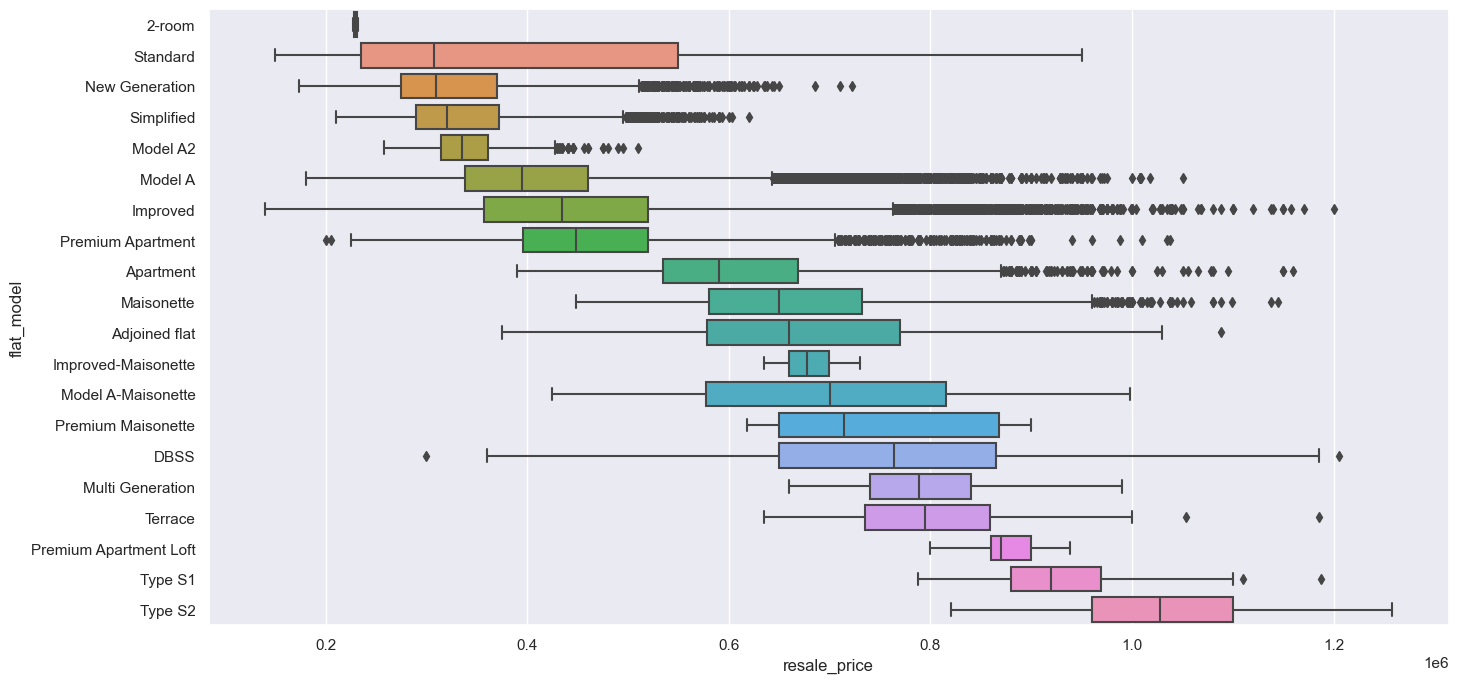

In [7]:
sorted_boxplot('flat_model',fm, rp)

Flat models is a category that not many peopleare familiar with. But visually, we can tell that this column is pretty useful for predicting resale_price. In a nutshell, there are different models of flats in Singapore. Maisonettes is a HDB flat with 2 floors in a unit for example so they fetch a relatively higher price. Terrace is a landed property in land scarce Singapore, which explains why the median sale price is one of the highest around. 

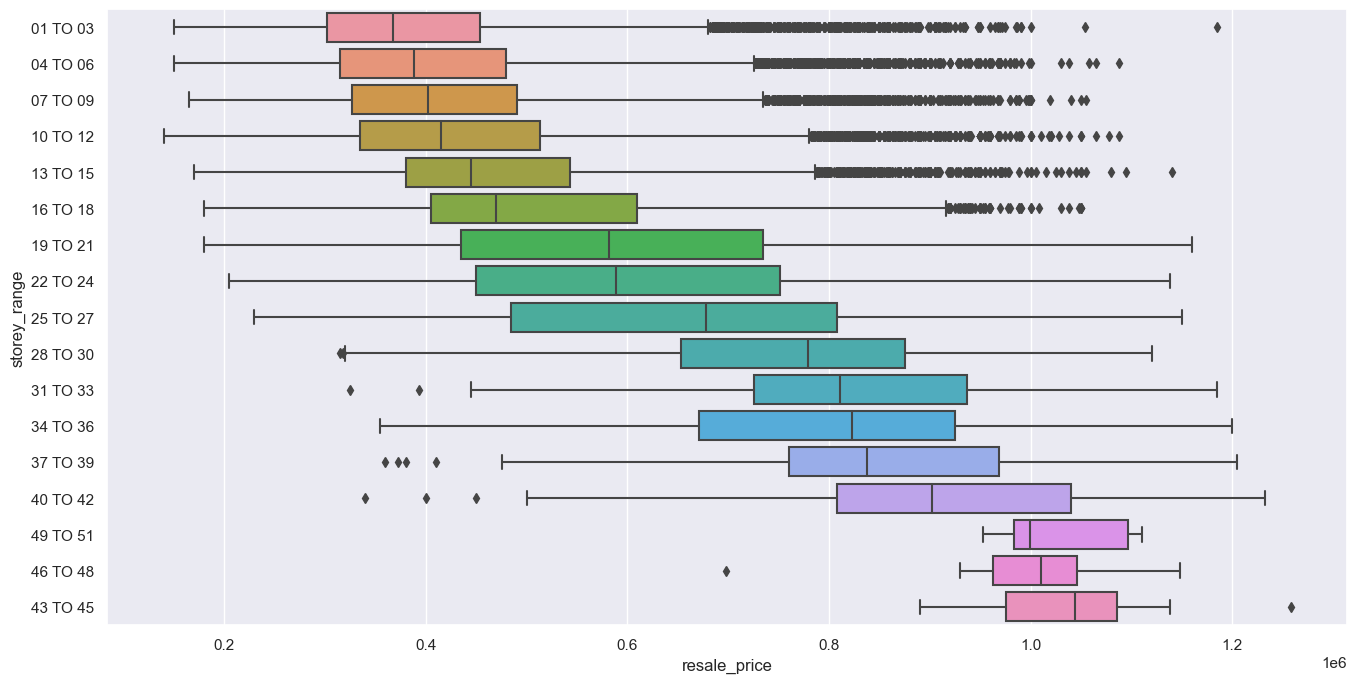

In [8]:
sorted_boxplot('storey_range',sr, rp)

Contextually, we know that higher floors sell for more and this clearly shows some correlation to the assumption.

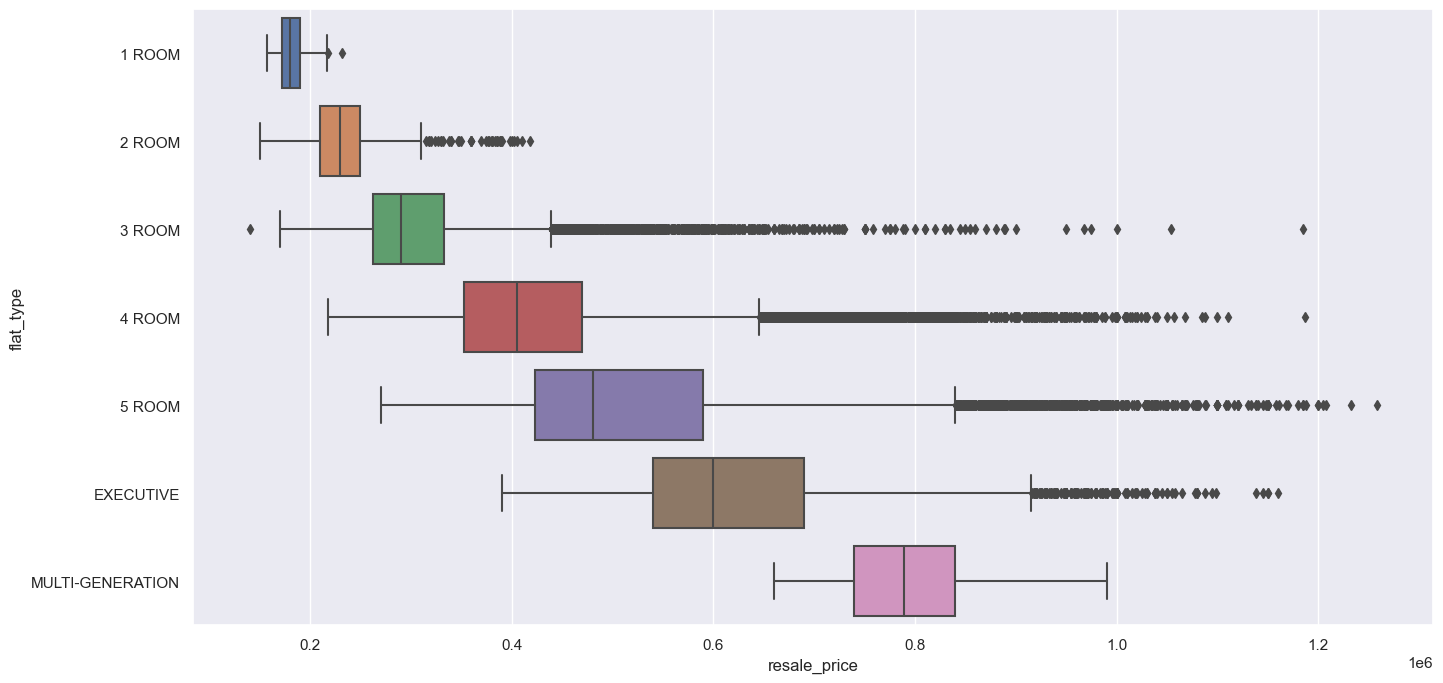

In [9]:
sorted_boxplot('flat_type',ft, rp)

This is straightforward. More rooms = more space = higher resale_price. Executive is 5 room flat type but with an additional space. Multi-Gen type is another type of flat with more rooms to accomodate several generations of families tolive together.

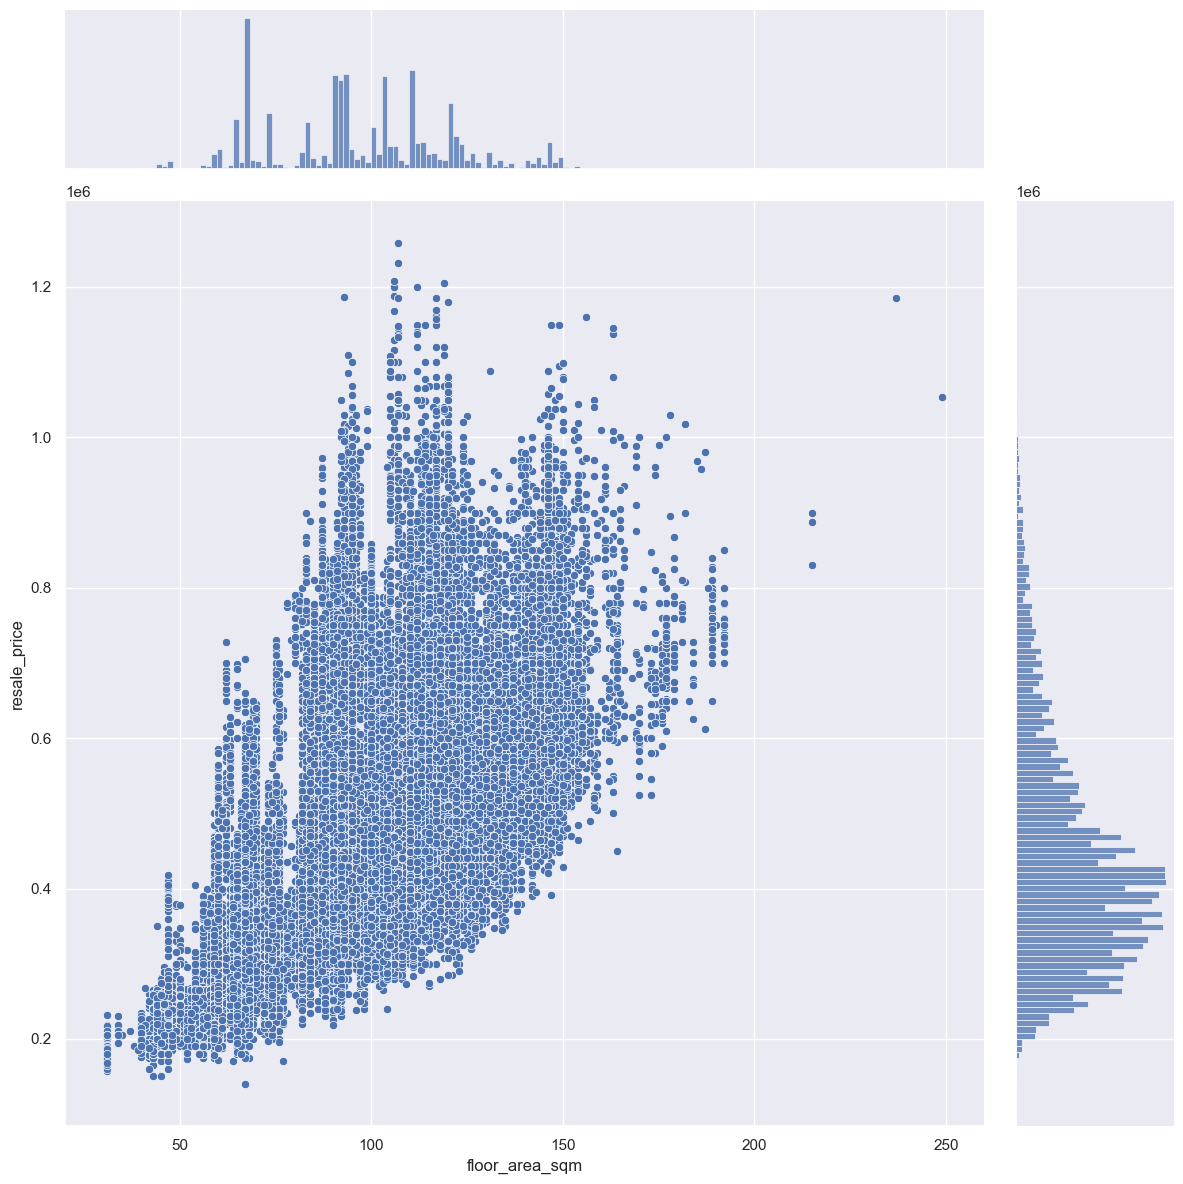

In [10]:
def scatter_plot(dfname, df1, df2):
    # Create a joint dataframe by concatenating the two variables
    jointDF = pd.concat([df1, df2], axis = 1).reindex(df1.index)

    # Draw jointplot of the two variables in the joined dataframe
    sb.jointplot(data = jointDF, x = dfname, y = "resale_price", height = 12)
    
scatter_plot('floor_area_sqm', fas, rp)

We can see the crazy range for resale_price when floor_area_sqm is around the 100-150 range. It goes to show that other columns affect the resale_price as well and not just the size of the flat. 

<AxesSubplot:>

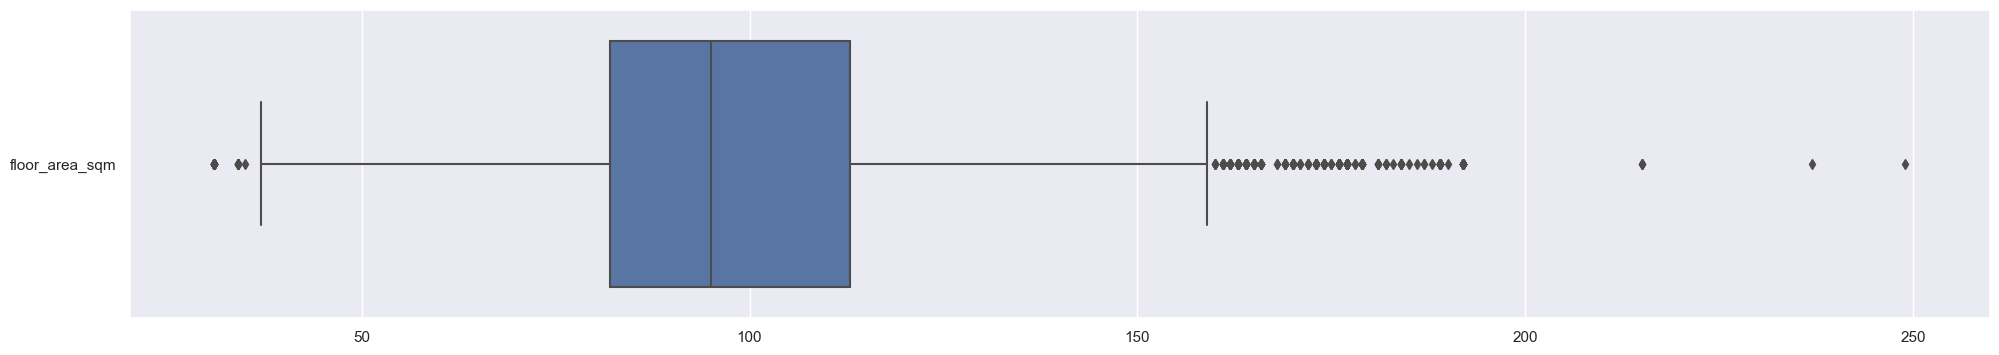

In [18]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = fas, orient = "h")

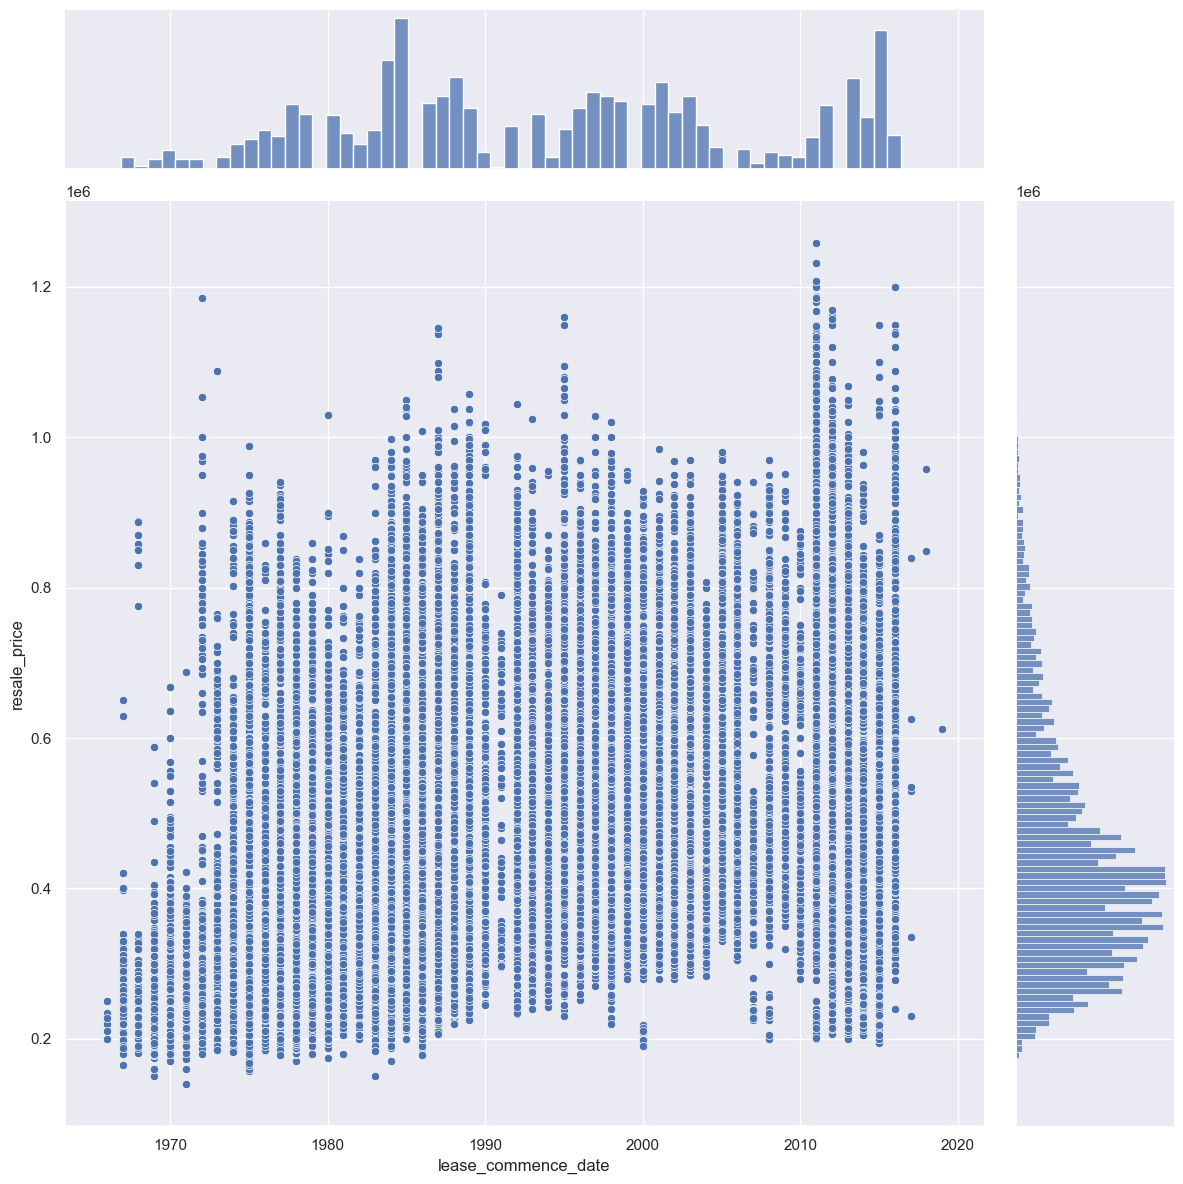

In [19]:
scatter_plot('lease_commence_date', lcd, rp)

This is an interesting scatter plot to see. Visually there seems to be a tiny correlation between the two columns. Usually, newer flats means longer leases means higher price. This plot shows that the lease play a tiny role in influencing resale_price. 

<AxesSubplot:>

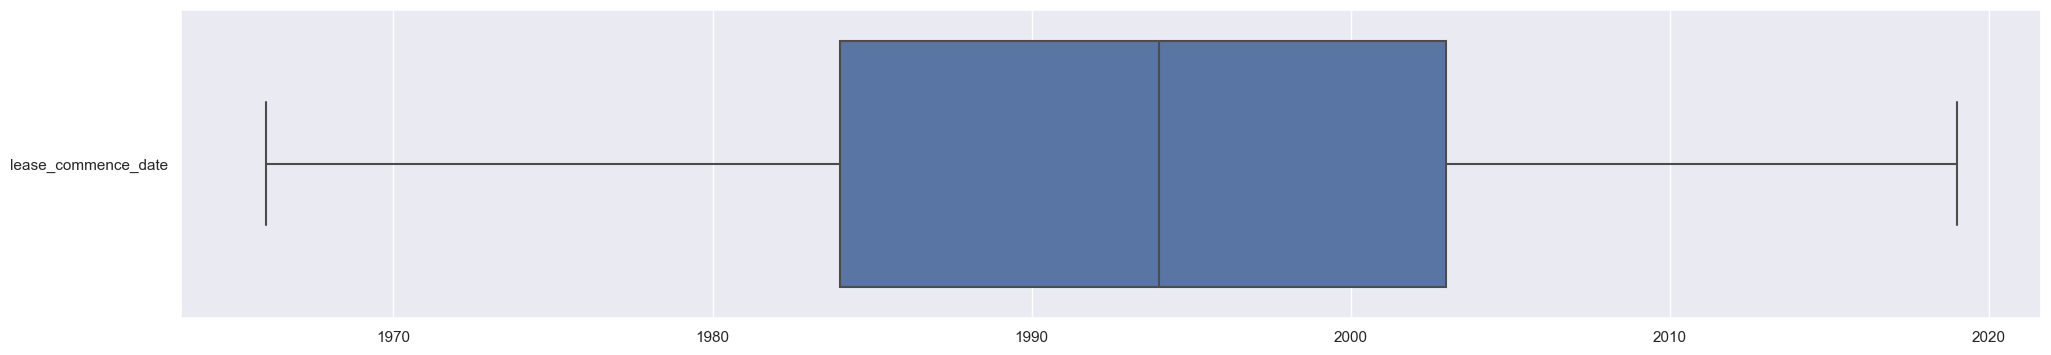

In [20]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = lcd, orient = "h")

<AxesSubplot:>

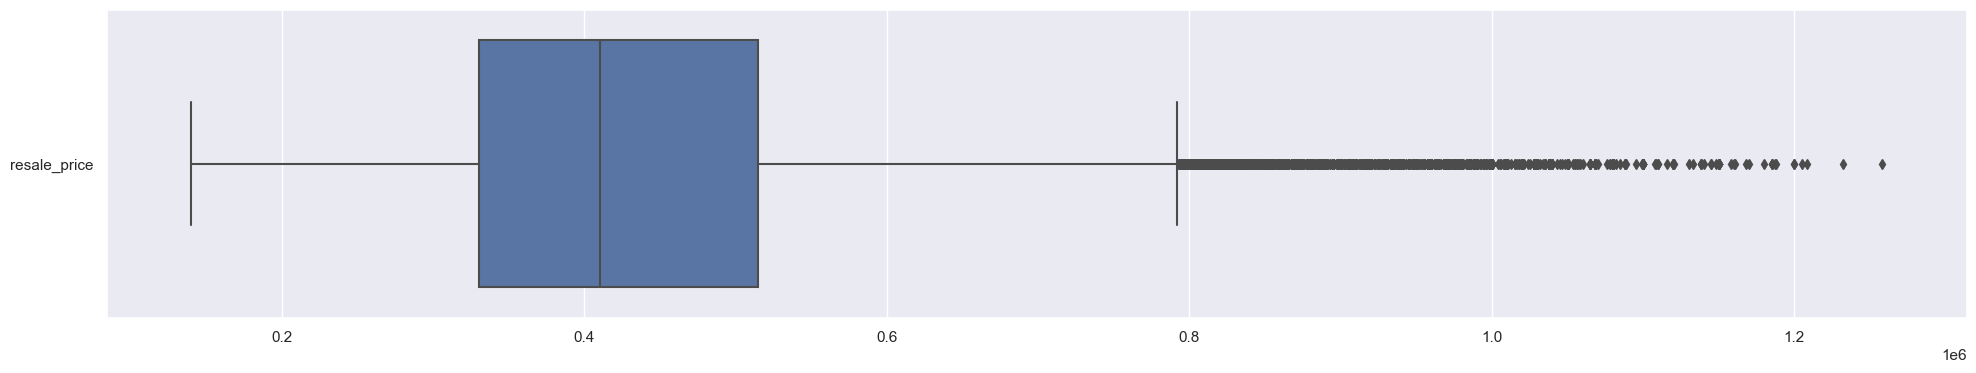

In [21]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = rp, orient = "h")

# 2. Introduction to Gradient Boosting Regression

__Machine learning model__: We have chosen Gradient Boosting Regression as our machine learning model. This model is useful for regression as it takes in weak regression models and builds a better one on top of it. It can handle numeric and categorical data as opposed to linear regression which can only handle numeric data. 

__Gradient Boosting Regression(GBR)__: This is a machine learning model that builds decision trees from input column(s) to predict an output column. It first guesses the average (resale_price for our case), then notes down the residual values (errors) from predicted to actual values. 

It will then build another tree based on the errors of the first tree and try to predict again. The the process repeats itself.

The tree built by GBR considers input columns like flat_type -> flat_model -> floor_area_sqm and so on before giving an output. 

GBR is prone to overfitting so it uses a learning weight to mitigate the issue. Learning weight scales the contribution from the new tree to ensure predictions aren't very stiff. It is also computationally intensive for large datasets. Also, the more it iterates itself, there will be diminishing returns. The residual values will get smaller and smaller per iteration but will never reach zero.

source: https://www.youtube.com/watch?v=3CC4N4z3GJc

# 3. Data preprocessing

In [22]:
town_encoded = pd.get_dummies(town, columns=['town'])
fm_encoded = pd.get_dummies(fm, columns=['flat_model'])
ft_encoded = pd.get_dummies(ft, columns=['flat_type'])
sr_encoded = pd.get_dummies(sr, columns=['storey_range'])

town_encoded

,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
80370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
80371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
80372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


__Encoding__: Before we are able to use GBR, we need to change categorical data into numeric data of 1s and 0s(True or Flase). As we can see from above, entry 0-4 has town_ANG MO KIO column set to 1 and the rest are set to 0.

# 4. GBR with one column to predict resale_price
__how we configure GBR__: in the GBR function, we split the dataset in to training set and testing set, 80% to 20% respectively. 

__Learning_rate__ refers to how errors from the previous decision trees affects the predictions for the next tree. is set to 0.1 so that there is some flexibility in predicting resale_price. It is set to be low to help avoid overfitting as well. 

__max_depth__ refers to how deep/complex the decision tree goes. Deeper means more is constraints are considered. It is set to 5 so because anything beyond that gives diminishing returns while needing a lot of computational power. 

__n_estimators__ controls the number of boosting stages to perform. It determines the number of weak deicision trees to predict. Every subsequent decision tree improves upon the previous one by minimizing the residual errors. It is set to 100 to get better predictions from one column to predict resale_price. Too much will result in overfitting, gives diminishing returns, and is computantionally expensive. 

__random state__ is set to 42. Controls the random seed given to each Tree estimator at each boosting iteration. (from scikit learn)

town to resale_price
Root Mean Squared Error: 	140698.74134556233
Explained Variance R^2: 	0.16002184991473223


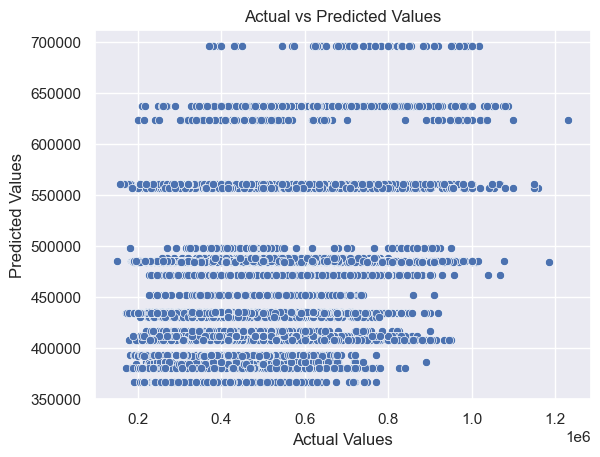

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Split the data into training and testing sets
def GBR(pred_name, predictor, response):
    predictor_en = pd.concat([response, predictor], axis = 1)
    train_data, test_data = train_test_split(predictor_en, test_size=0.2)
    X_train = train_data.drop('resale_price', axis=1)
    y_train = train_data['resale_price']
    X_test = test_data.drop('resale_price', axis=1)
    y_test = test_data['resale_price']

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2 = r2_score(y_test, y_pred)
    print(f"{pred_name} to resale_price")
    print(f"Root Mean Squared Error: \t{rmse}")
    print(f"Explained Variance R^2: \t{r2}")
    
    # Create a scatter plot of the actual vs predicted values
    sb.scatterplot(x=y_test, y=y_pred)

    # Add labels and title
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()
    
GBR('town', town_encoded, rp)

Here we see how GBR predicts resale_price against town. Obviously it is terrible as the R^2 value is close to 0. Also, in a perfect predicted to actual scatter plot, we should see a nice diagonal line, which this plot is not. We have decided to show RMS instead of MSE as it shows numbers that are more relatable. 

flat_model to resale_price
Root Mean Squared Error: 	125258.05340375128
Explained Variance R^2: 	0.3399538114338456


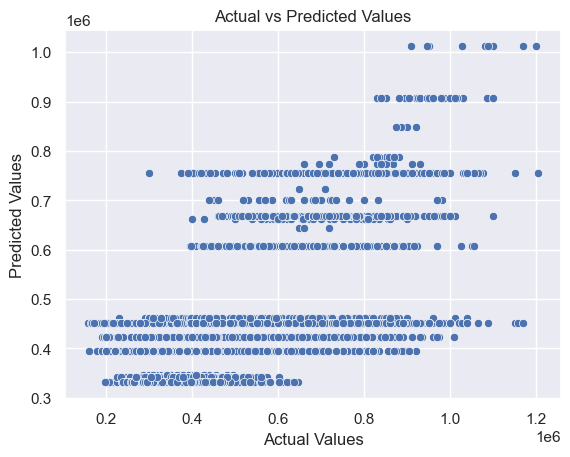

In [31]:
GBR('flat_model', fm_encoded, rp)

storey_range to resale_price
Root Mean Squared Error: 	138981.92272792262
Explained Variance R^2: 	0.16728750243042556


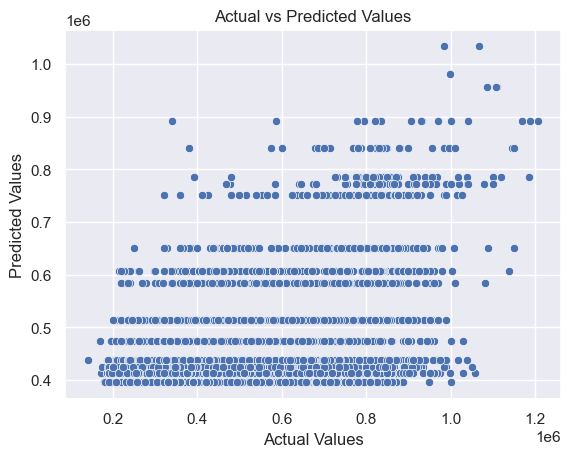

In [32]:
GBR('storey_range', sr_encoded, rp)

flat_type to resale_price
Root Mean Squared Error: 	117281.28962984217
Explained Variance R^2: 	0.41154537376848044


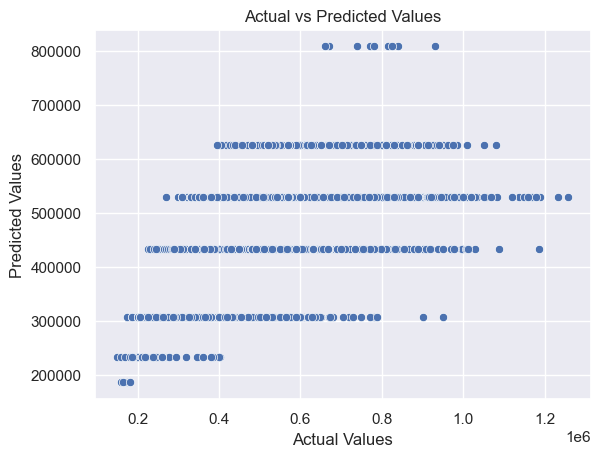

In [33]:
GBR('flat_type', ft_encoded, rp)

floor_area_sqm to resale_price
Root Mean Squared Error: 	112202.96184597071
Explained Variance R^2: 	0.46489961544902647


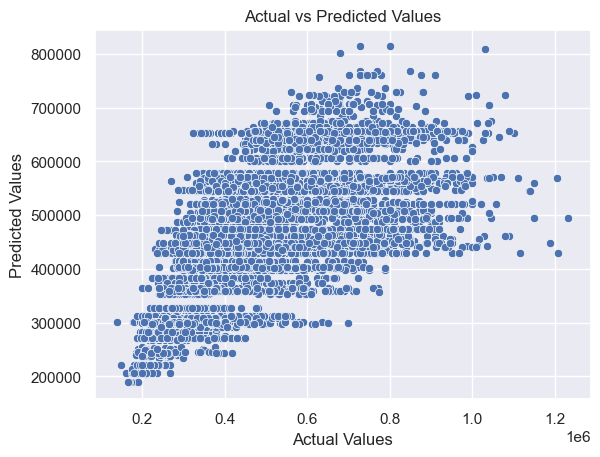

In [34]:
GBR('floor_area_sqm', fas, rp)

lease_commence_date to resale_price
Root Mean Squared Error: 	137499.68368707775
Explained Variance R^2: 	0.21034240017228722


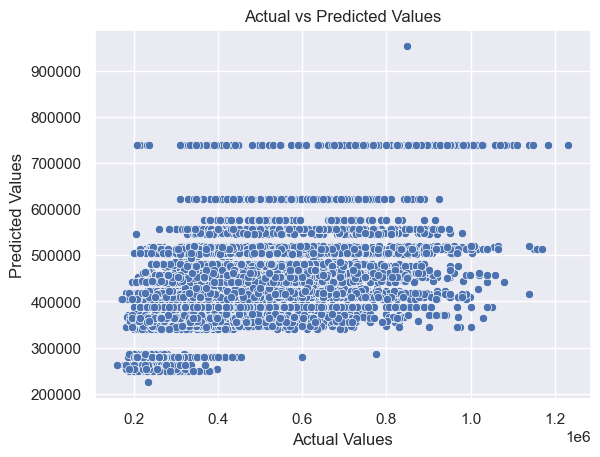

In [35]:
GBR('lease_commence_date', lcd, rp)

__Remarks__: Out of all columns, we can see that floor_area_sqm and flat_type are somewhat reliable in predicting resale_price as they have high R^2 compared to the rest. Honorable mention goes to flat_model. 

# 5. GBR with multiple columns to predict resale_price

Lets see what happens when we take only the 3 'reliable' columns to predict resale_price. 

C:\Users\Soul_M\AppData\Local\Temp\ipykernel_14048\1152515400.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maindf2[col] = le.fit_transform(maindf2[col])


Root Mean Squared Error:	95000.32561953086
Explained Variance R^2: 	0.6225453831267511


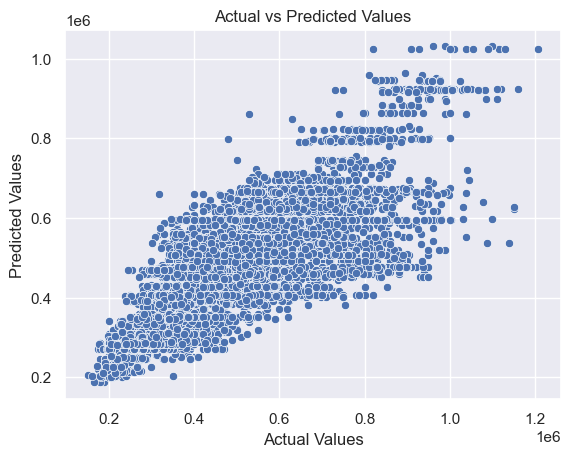

In [36]:
from sklearn.preprocessing import LabelEncoder

maindf2 = maindf[['flat_model', 'flat_type', 'resale_price', 'floor_area_sqm']]

# Encode the categorical variables using LabelEncoder
cat_cols = ['flat_model', 'flat_type']
for col in cat_cols:
    le = LabelEncoder()
    maindf2[col] = le.fit_transform(maindf2[col])

# Split the data into training and testing sets
X = maindf2.drop('resale_price', axis=1)
y = maindf2['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor model
model = GradientBoostingRegressor(max_depth = 5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance using mean squared error
mse = mean_squared_error(y_test, y_pred)**0.5
print(f"Root Mean Squared Error:\t{mse}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance R^2: \t{r2}")
# Create a scatter plot of the actual vs predicted values
sb.scatterplot(x=y_test, y=y_pred)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

__Remarks__: We see a huge improvement R^2 as it estimates to 0.6 as opposed to 0.4 for flat_type or floor_area_sqm columns alone. Also, there is a significant drop in RMSE to  around 95000 as opposed to around 100000. This time, we will add all six columns in to predict resale_price

C:\Users\Soul_M\AppData\Local\Temp\ipykernel_14048\2352392287.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maindf2[col] = le.fit_transform(maindf2[col])


Root Mean Squared Error:	45856.70377244085
Explained Variance R^2: 	0.9120531635324016


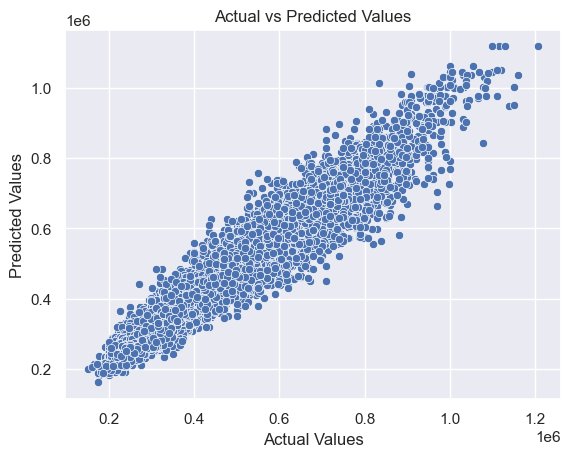

In [37]:
from sklearn.preprocessing import LabelEncoder

maindf2 = maindf[['flat_model', 'flat_type', 'storey_range', 'town', 'resale_price', 'floor_area_sqm', 'lease_commence_date']]

# Encode the categorical variables using LabelEncoder
cat_cols = ['flat_model', 'flat_type', 'storey_range', 'town']
for col in cat_cols:
    le = LabelEncoder()
    maindf2[col] = le.fit_transform(maindf2[col])

# Split the data into training and testing sets
X = maindf2.drop('resale_price', axis=1)
y = maindf2['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor model
model = GradientBoostingRegressor(max_depth = 5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance using mean squared error
GBR_rmse = mean_squared_error(y_test, y_pred)**0.5
print(f"Root Mean Squared Error:\t{GBR_rmse}")
GBR_r2 = r2_score(y_test, y_pred)
print(f"Explained Variance R^2: \t{GBR_r2}")
# Create a scatter plot of the actual vs predicted values
sb.scatterplot(x=y_test, y=y_pred)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

__Remarks__: Even though the columns lease_commence_date, storey_range, and town are unreliable in predicting resale_price, they contributed a lot to give rise to an excellent model for prediction. The R^2 is 0.912 which is insane when compared to the earlier regression models, plus the RMSE is under 50000 as well.  

# 6. Comparing GBR with linear regression model and random guessing

Now, let's see how this model matches up with linear regression to predict resale_price. This only works with numeric columns floor_area_sqm and lease_commence_date though.


Intercept 	: b =  [49228.88251944]
Coefficients 	: a =  [[3992.73574806]]
floor_area_sqm to resale_price
Root Mean Squared Error: 	120346.26037383304
Explained Variance R^2: 	0.3949158615200772


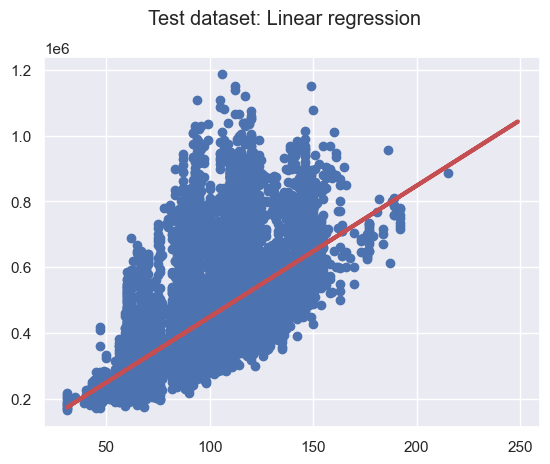

(120346.26037383304, 0.3949158615200772)

In [38]:
from sklearn.linear_model import LinearRegression

def linreg_func(pred_name,predictor, response):
# Create a Linear Regression object
    linreg = LinearRegression()

# Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size = 0.20)

# Train the Linear Regression model
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
# Coefficients of the Linear Regression line
    print('Intercept \t: b = ', linreg.intercept_)
    print('Coefficients \t: a = ', linreg.coef_)
# evaluate the model
    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2 = r2_score(y_test, y_pred)
    print(f"{pred_name} to resale_price")
    print(f"Root Mean Squared Error: \t{rmse}")
    print(f"Explained Variance R^2: \t{r2}")
    regline_x = X_train
    regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Plot the Linear Regression line
    plt.scatter(X_test, y_test)
    plt.plot(regline_x, regline_y, 'r', linewidth = 3)
    plt.suptitle("Test dataset: Linear regression")
    plt.show()
    
    return rmse, r2
    
linreg_func('floor_area_sqm',fas,rp)

Intercept 	: b =  [-7354325.59887428]
Coefficients 	: a =  [[3908.30625418]]
lease_commence_date to resale_price
Root Mean Squared Error: 	145177.31903730804
Explained Variance R^2: 	0.11174242982203175


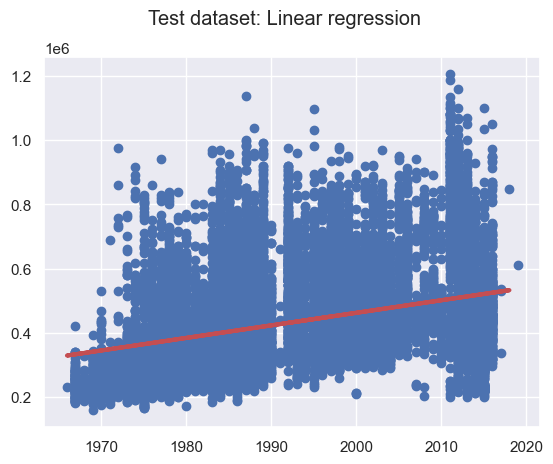

(145177.31903730804, 0.11174242982203175)

In [46]:
linreg_func('lease_commence_date', lcd, rp)

Lets try to do some preprocessing and cleaning and try to do a better linear regression model to go againt the GBR model. Remember how removing outliers is considered tricky business? Instead of blindly removing outliers, perhaps we can remove resale_price outliers based on categorical data. For this linreg model, lets try to remove resale_price outliers based on flat_model. We will also be removing abnormally large floor_area_sqm entries as well. 

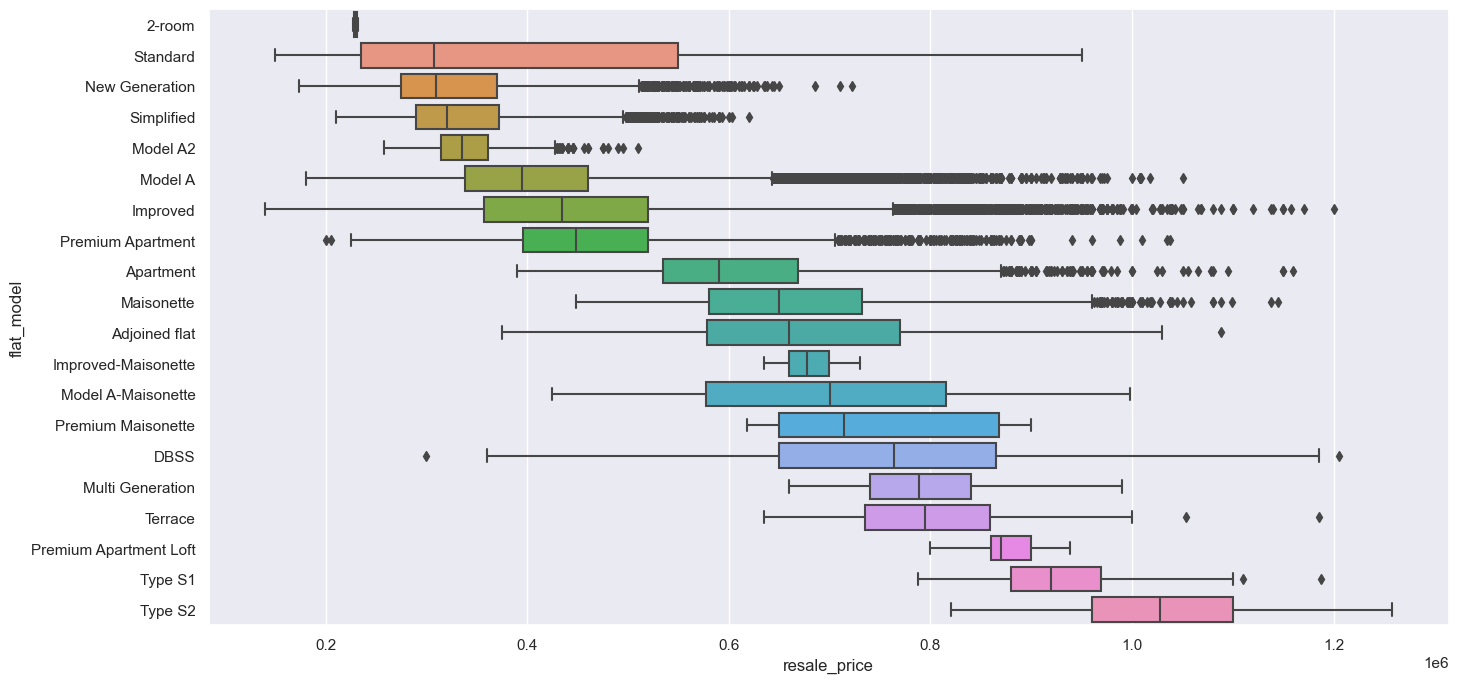

In [40]:
sorted_boxplot('flat_model',fm, rp)

In [41]:
all_idx = []

def tag_outliers(group):#tags rp outliers from every individual category
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    return group[(group <= Q1 - 1.5*IQR) | (group >= Q3 + 1.5*IQR)].index

rp_fm = pd.concat([rp, fm], axis = 1)

rp_fm_cleaned = rp_fm.groupby('flat_model')['resale_price'].apply(tag_outliers).reset_index()

all_idx = []
for idx in rp_fm_cleaned['resale_price'].tolist():
    all_idx += idx.tolist()

#tagging outliers from floor_area_sqm
Q1 = float(fas.quantile(0.25))
Q3 = float(fas.quantile(0.75))
IQR = Q3 - Q1

j = 0
for i in pd.to_numeric(fas.floor_area_sqm):
    if i < Q1 - 1.5 * IQR or i > Q3 + 1.5 * IQR:
        if j not in all_idx:
            all_idx.append(j)
    j += 1

print(all_idx)

[75855, 55, 1856, 2497, 5752, 7505, 9327, 9328, 9508, 9949, 10854, 11094, 11721, 13205, 13551, 13687, 13981, 14772, 16706, 17177, 18430, 19448, 19449, 19450, 20157, 20312, 21330, 22867, 23391, 24248, 24745, 25880, 25881, 27804, 28324, 28465, 29749, 29948, 30489, 31827, 32163, 33391, 33753, 34304, 35030, 36094, 36321, 36508, 36509, 40172, 41543, 41729, 42857, 42858, 43235, 45085, 51287, 51718, 51972, 52099, 53087, 53764, 53765, 54050, 59906, 61863, 63752, 65855, 66707, 69011, 69012, 70846, 72123, 74575, 75720, 77568, 78187, 79468, 79792, 80077, 43241, 53514, 54, 121, 250, 414, 791, 792, 1029, 1030, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1429, 1430, 1738, 1739, 1740, 1854, 2109, 2110, 2111, 2353, 2354, 2357, 2491, 2640, 2641, 2642, 2643, 2832, 2833, 2834, 3212, 3213, 3214, 3215, 3219, 3485, 3487, 3489, 3491, 3492, 3493, 3924, 3925, 3926, 3927, 4257, 4396, 4397, 4540, 4541, 4615, 4749, 4750, 4751, 5133, 5360, 5361, 5362, 5363, 5364, 6105, 6107, 6235, 6239, 6240, 6241, 6395, 6396,

In [42]:
#dropping tagged outliers 

maindf1 = pd.read_csv('resale_flat_prices_based_on_registration_date_from_jan_2017_onwards.csv')
maindf1.drop(axis = 0,               # 0 drops row 1 drops column
                index = all_idx, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
maindf1

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,Improved,1987,66 years 03 months,440000.0
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,Improved,1987,65 years 06 months,458000.0
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,Improved,1987,66 years 04 months,490000.0
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,Maisonette,1987,66 years 03 months,558000.0


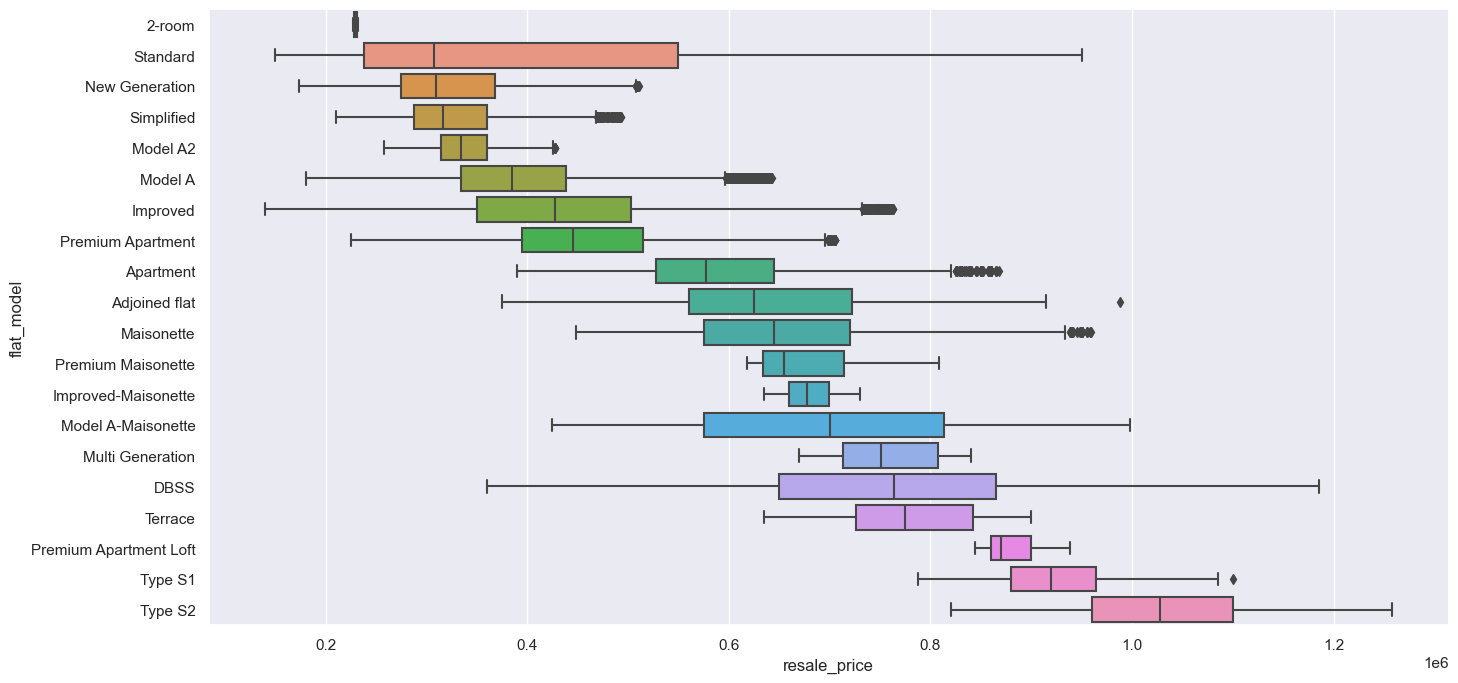

In [43]:
sorted_boxplot('flat_model',maindf1['flat_model'], maindf1['resale_price'])

With Outliers removed, this is what how flat_model compares to reslae_price now. If we were to remove resale_price outliers blindly, Type S1 and Type S2 entries will be wiped clean. A misrepresentation of the overall dataset.

Intercept 	: b =  [49063.24909863]
Coefficients 	: a =  [[3839.54617895]]
floor_area_sqm to resale_price
Root Mean Squared Error: 	97320.74307783833
Explained Variance R^2: 	0.46903968336638546


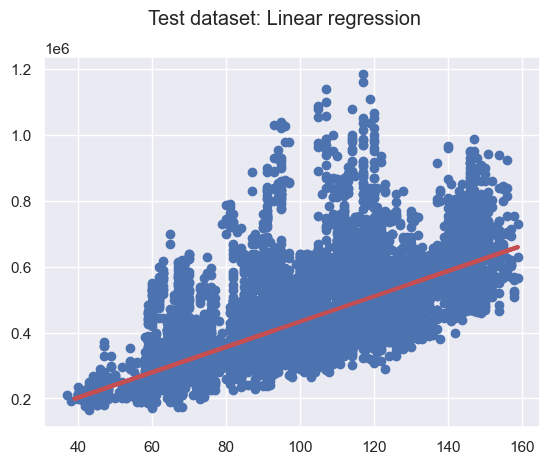

In [44]:
fas1 = pd.DataFrame(maindf1['floor_area_sqm'])
rp1 = pd.DataFrame(maindf1['resale_price'])
lcd1 = pd.DataFrame(maindf1['lease_commence_date'])

fas_rmse, fas_r2 = linreg_func('floor_area_sqm', fas1, rp1)

We see a noticeable improvement in R^2 value and RMSE. Previously, R^2 was around 0.395 and RMSE was around 120000

Intercept 	: b =  [-6069480.99496504]
Coefficients 	: a =  [[3255.63492275]]
lease_commence_date to resale_price
Root Mean Squared Error: 	127223.35369479144
Explained Variance R^2: 	0.09687837347109063


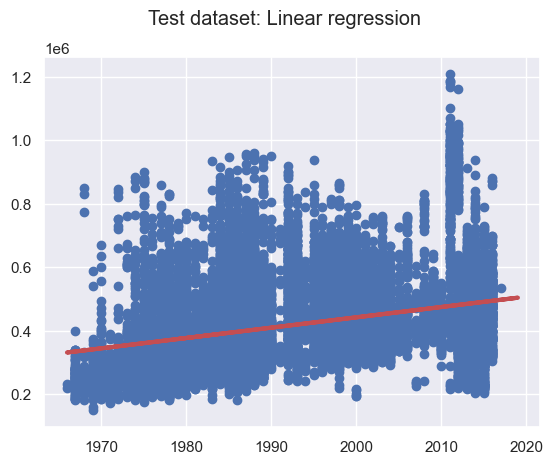

In [47]:
lcd_rmse, lcd_r2 = linreg_func('lease_commence_date', lcd1, rp1)

Surprisingly, the linear regression model results are mixed after cleaning. Previously, R^2 was around 0.105 and RMSE was around 145000. 

Lets see how random guessing would fare against our GBR model as well

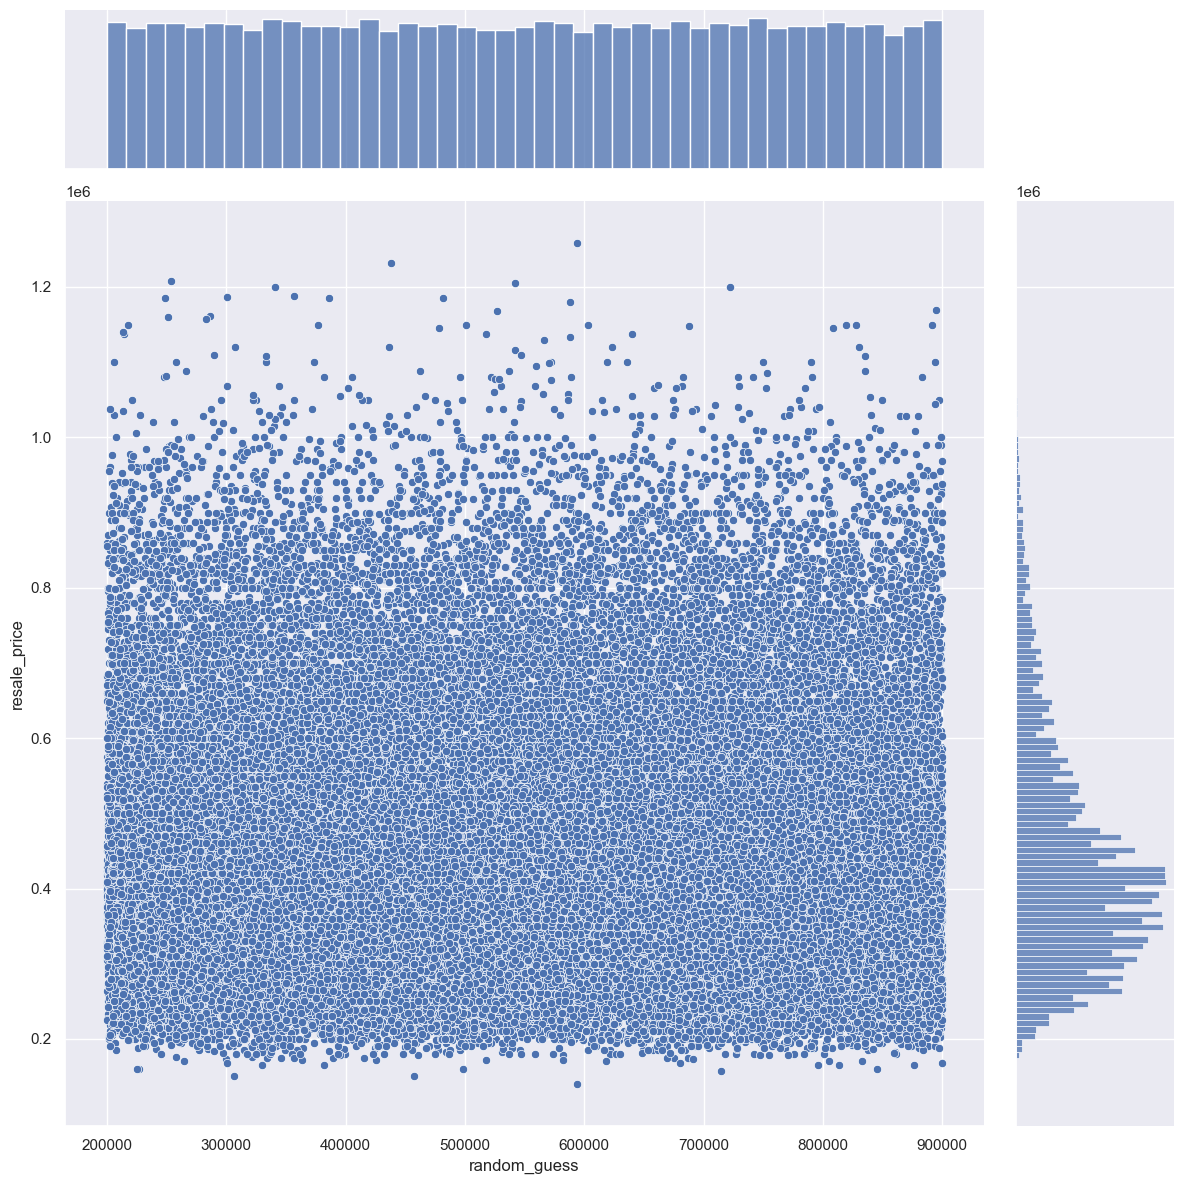

In [51]:
import random

rp_randomguess = pd.DataFrame(maindf['resale_price'])
rp_randomguess['random_guess'] = np.random.randint(low=200000, high=900000, size=len(rp_randomguess))
rp_randomguess = rp_randomguess.drop('resale_price', axis=1)

scatter_plot('random_guess', rp_randomguess, rp)

Intercept 	: b =  [441038.07258957]
Coefficients 	: a =  [[-0.00280294]]
random_guess to resale_price
Root Mean Squared Error: 	152542.27880716554
Explained Variance R^2: 	-2.347450280493213e-05


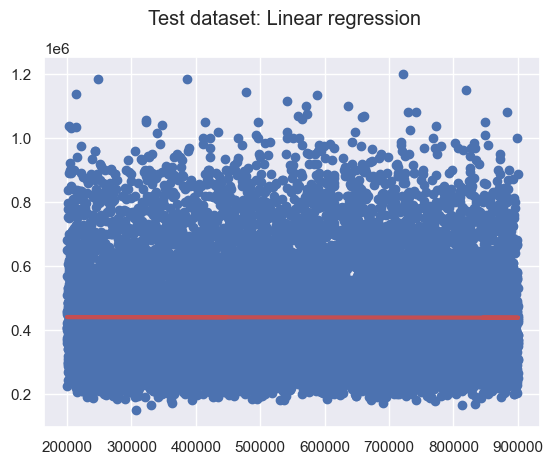

In [52]:
rand_rmse, rand_r2 = linreg_func('random_guess', rp_randomguess, rp)

The R^2 value is messed up but frankly speaking, random guessing is straight up terrible to predict resale_price

In [53]:
print("Comparing the goodness of fit for GBR, linear regression model, and random guessing:\n")

print("GBR goodness of fit:")
print("Root Mean Squared Error:\t", GBR_rmse)
print("Explained Variance R^2:\t\t", GBR_r2)
print()
print("linear regression(floor_area_sqm) goodness of fit:")
print("Root Mean Squared Error:\t", fas_rmse)
print("Explained Variance R^2:\t\t", fas_r2)
print()
print("linear regression(lease_commence_date) goodness of fit:")
print("Root Mean Squared Error:\t", lcd_rmse)
print("Explained Variance R^2:\t\t", lcd_r2)
print()
print("random guessing goodness of fit:")
print("Root Mean Squared Error:\t", rand_rmse)
print("Explained Variance R^2:\t\t", rand_r2)

Comparing the goodness of fit for GBR, linear regression model, and random guessing:

GBR goodness of fit:
Root Mean Squared Error:	 45856.70377244085
Explained Variance R^2:		 0.9120531635324016

linear regression(floor_area_sqm) goodness of fit:
Root Mean Squared Error:	 97320.74307783833
Explained Variance R^2:		 0.46903968336638546

linear regression(lease_commence_date) goodness of fit:
Root Mean Squared Error:	 127223.35369479144
Explained Variance R^2:		 0.09687837347109063

random guessing goodness of fit:
Root Mean Squared Error:	 152542.27880716554
Explained Variance R^2:		 -2.347450280493213e-05


As we can see, GBR performs the best as the R^2 value is the closest to 1 and the RMSE is the lowest. 

# 7. More experimnts with GBR hyperparameters
For sklearn's GBR, learning rate is set to 0.1 by default. lets see what happens when we set it to 0.8 instead.

C:\Users\Soul_M\AppData\Local\Temp\ipykernel_8768\2615736186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maindf2[col] = le.fit_transform(maindf2[col])


Root Mean Squared Error:	35937.59635327832
Explained Variance R^2: 	0.9459852205681931


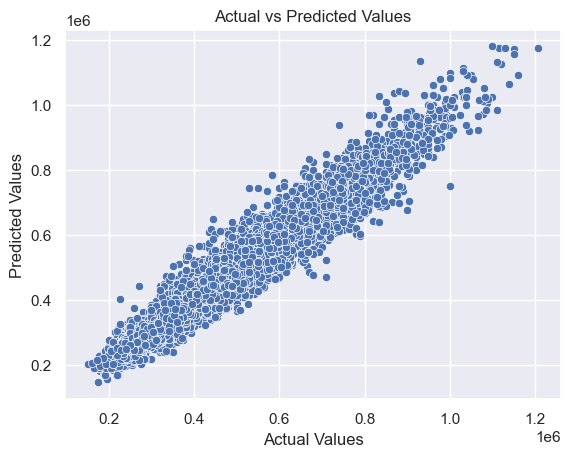

Original GBR goodness of fit:
Root Mean Squared Error:	 45856.19881041931
Explained Variance R^2:		 0.9120551004168335


In [45]:
maindf2 = maindf[['flat_model', 'flat_type', 'storey_range', 'town', 'resale_price', 'floor_area_sqm', 'lease_commence_date']]

# Encode the categorical variables using LabelEncoder
cat_cols = ['flat_model', 'flat_type', 'storey_range', 'town']
for col in cat_cols:
    le = LabelEncoder()
    maindf2[col] = le.fit_transform(maindf2[col])

# Split the data into training and testing sets
X = maindf2.drop('resale_price', axis=1)
y = maindf2['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor model
model = GradientBoostingRegressor(max_depth = 5, learning_rate = 0.8)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance using mean squared error
rmse = mean_squared_error(y_test, y_pred)**0.5
print(f"Root Mean Squared Error:\t{rmse}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance R^2: \t{r2}")
# Create a scatter plot of the actual vs predicted values
sb.scatterplot(x=y_test, y=y_pred)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

print("Original GBR goodness of fit:")
print("Root Mean Squared Error:\t", GBR_rmse)
print("Explained Variance R^2:\t\t", GBR_r2)

Looks like this model has better fit against the test data. However, there is a problem called overfitting where the regression model fits too well and performs poorly against other datasets. Admittedly, this problem can be applied to the original GBR model as well. 

For sklearn's GBR, n_estimators is set to 100 by default. lets see what happens when we set it to 10 instead

C:\Users\Soul_M\AppData\Local\Temp\ipykernel_8768\703443698.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maindf2[col] = le.fit_transform(maindf2[col])


Root Mean Squared Error:	97509.94381042737
Explained Variance R^2: 	0.6023395803504692


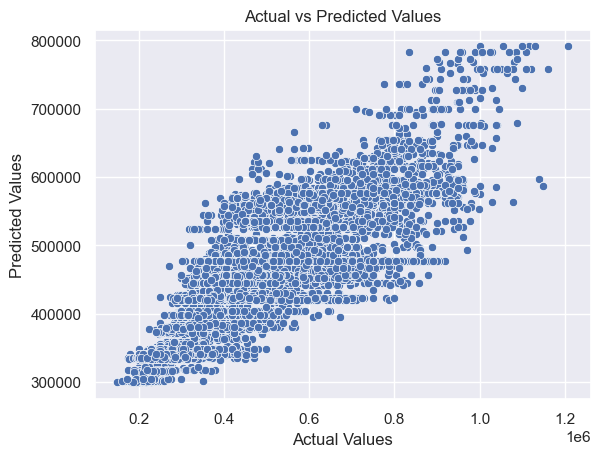

Original GBR goodness of fit:
Root Mean Squared Error:	 45856.19881041931
Explained Variance R^2:		 0.9120551004168335


In [46]:
maindf2 = maindf[['flat_model', 'flat_type', 'storey_range', 'town', 'resale_price', 'floor_area_sqm', 'lease_commence_date']]

# Encode the categorical variables using LabelEncoder
cat_cols = ['flat_model', 'flat_type', 'storey_range', 'town']
for col in cat_cols:
    le = LabelEncoder()
    maindf2[col] = le.fit_transform(maindf2[col])

# Split the data into training and testing sets
X = maindf2.drop('resale_price', axis=1)
y = maindf2['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor model
model = GradientBoostingRegressor(max_depth = 5, n_estimators = 10)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance using mean squared error
rmse = mean_squared_error(y_test, y_pred)**0.5
print(f"Root Mean Squared Error:\t{rmse}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance R^2: \t{r2}")
# Create a scatter plot of the actual vs predicted values
sb.scatterplot(x=y_test, y=y_pred)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

print("Original GBR goodness of fit:")
print("Root Mean Squared Error:\t", GBR_rmse)
print("Explained Variance R^2:\t\t", GBR_r2)

Looks like it is better for n_estimators to be set higher after all. However, we cannot set it too high as it gives diminishing returns and more computationally intensive

Finally, max_depth is set to 5. lets see what happens when we set it to 10 instead

C:\Users\Soul_M\AppData\Local\Temp\ipykernel_8768\1728835090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maindf2[col] = le.fit_transform(maindf2[col])


Root Mean Squared Error:	32915.24701173443
Explained Variance R^2: 	0.9546884632810516


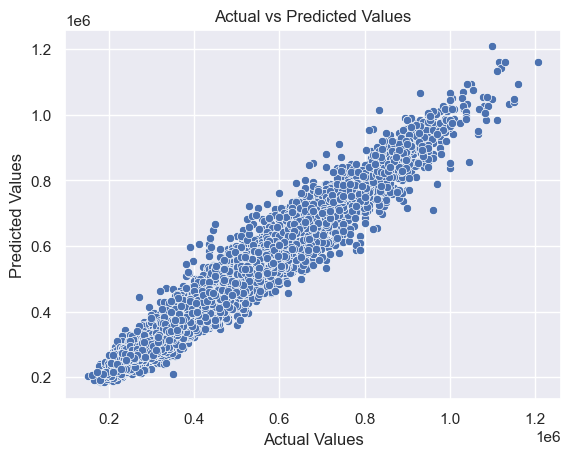

Original GBR goodness of fit:
Root Mean Squared Error:	 45856.19881041931
Explained Variance R^2:		 0.9120551004168335


In [48]:
maindf2 = maindf[['flat_model', 'flat_type', 'storey_range', 'town', 'resale_price', 'floor_area_sqm', 'lease_commence_date']]

# Encode the categorical variables using LabelEncoder
cat_cols = ['flat_model', 'flat_type', 'storey_range', 'town']
for col in cat_cols:
    le = LabelEncoder()
    maindf2[col] = le.fit_transform(maindf2[col])

# Split the data into training and testing sets
X = maindf2.drop('resale_price', axis=1)
y = maindf2['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor model
model = GradientBoostingRegressor(max_depth = 10)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance using mean squared error
rmse = mean_squared_error(y_test, y_pred)**0.5
print(f"Root Mean Squared Error:\t{rmse}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance R^2: \t{r2}")
# Create a scatter plot of the actual vs predicted values
sb.scatterplot(x=y_test, y=y_pred)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

print("Original GBR goodness of fit:")
print("Root Mean Squared Error:\t", GBR_rmse)
print("Explained Variance R^2:\t\t", GBR_r2)

By now, the same points will begin to repeat itself. Yes, results are better as the R^2 is closer to 1 as opposed to the original. But there is a problem of overfitting, higher max depth == more computationally intensive and more max depth gives diminishing returns

# 8.Conclusion

For our experiments, first, we looked at how GBR performs when it considers one column to predict resale_price. GBR performs terribly here.

Then we see how it performs when we give it multiple columns to predict resale_price. We can see a vast improvement when more data is given for GBR. Even the 'unreliable' columns help. 

Afterwards, we made a linear regression model, cleared the outliers and compared how the two models performed. Linear regression is limited when it comes to 

Finally, we adjusted GBR's hyperparameters to see different results we can get.

With this dataset and GBR, we can now predict resale_price reliably, as long as we have the 6 columns that are used. 

__limitations of our model__: It is prone to overfitting. Good R^2 results with low RMSE does not neccessarily mean that it will perform well with HDB resale data from another time period. Nowadays the rent in Singapore is rising rapidly, making properties more valuable. This change will make properties more valuable, leading to a change in resale_prices. This phenomena affect our machine learning model's performance. Perhaps we can revisit this again once we have the data from 2020 - 2025?

We also made the decision to not remove any data entries because this is tricky business. A lot of careful consideration is needed before removing them. Perhaps after removal of outliers, our model can perform better as well. 